In [1]:
import os
from pathlib import Path
import logging
import random
import itertools
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST,
    PREDICTION,
    SAVED_MODELS
)

device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

Load dataset

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Manage...,"[quality management, quality planning]"
1,General Quality System Requirements […] Manage...,[quality management]
2,General Quality System Requirements […] Manage...,[quality management]


Binarize target (using multi-label binarizer) for multi-label classification

In [3]:
features = Features(config)
df_features = features.build(df)

df_features.head(3)

2022-12-13 04:44:04,768 - capstone.utils.utils - INFO - func:clean took: 3.65 sec
2022-12-13 04:44:05,622 - capstone.utils.utils - INFO - func:fit took: 4.51 sec
2022-12-13 04:44:07,695 - capstone.utils.utils - INFO - func:clean took: 2.07 sec
2022-12-13 04:44:07,960 - capstone.utils.utils - INFO - func:transform took: 2.34 sec
2022-12-13 04:44:07,961 - capstone.utils.utils - INFO - func:fit_transform took: 6.85 sec
2022-12-13 04:44:08,189 - capstone.utils.utils - INFO - func:clean took: 0.23 sec
2022-12-13 04:44:08,221 - capstone.utils.utils - INFO - func:transform took: 0.26 sec
2022-12-13 04:44:08,245 - capstone.utils.utils - INFO - func:build took: 7.15 sec


,Text,Standard mapping?,Original Text,audit inspection,calibration,capa,change controls,clinical research,controled substances,csv,...,word__unit generally,word__unit generally shared,word__use device,word__used manufacture,word__used production,word__validation study,word__way ensures,word__wholesale distributor,word__written procedure,Split
0,good practice quality control qc responsibilit...,"[laboratory controls, stability programs]",Good practices in quality control […] Other QC...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.439675,Development
1,good practice quality control basic requiremen...,"[capa, nc, rca]",Good practices in quality control […] The basi...,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Development
2,validation process validation program critical...,[process & packaging validation],Validation […] Process Validation Program […] ...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.285952,0.0,0.0,0.000000,Development


Split into development and test sets

In [4]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
Y_test = test[features.mlb.classes_].copy()

Target distribution for development and test sets

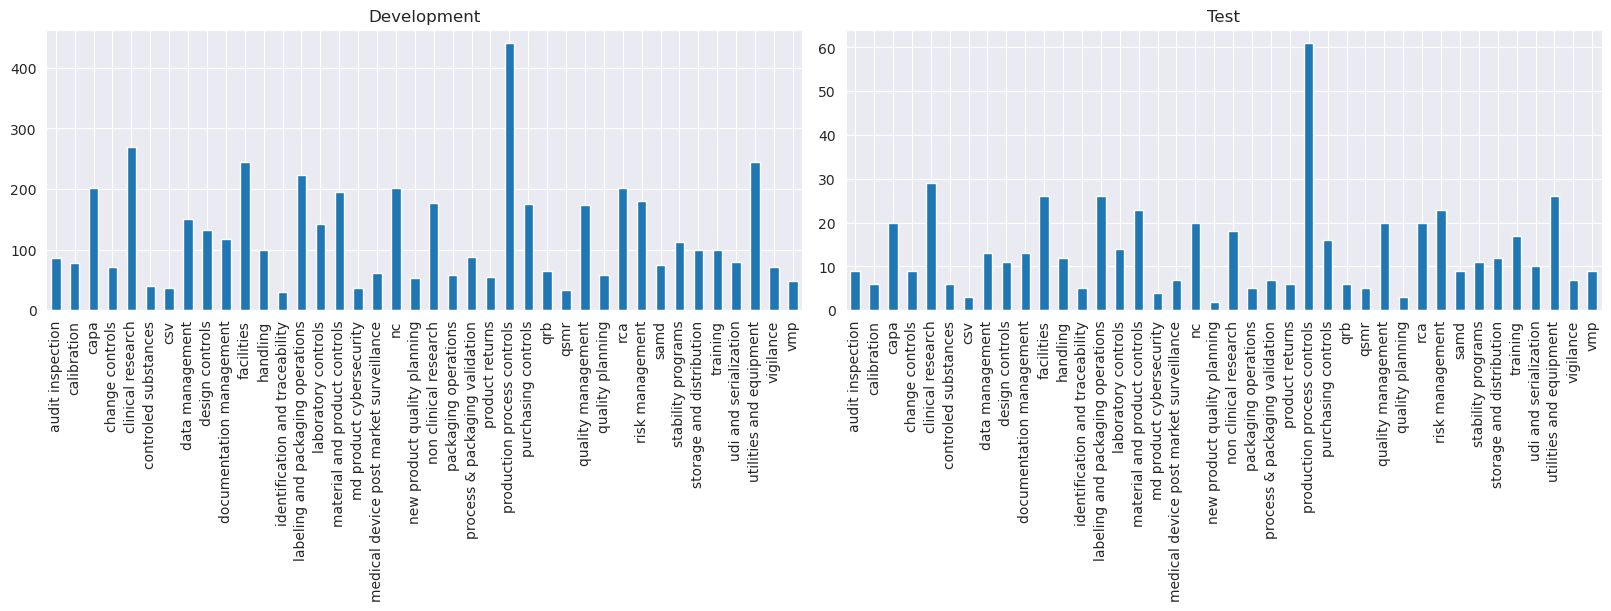

In [5]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
Y_dev.sum(axis=0).plot.bar(ax=ax[0])
Y_test.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Development")
ax[1].set_title("Test");

Split development set into train and validation set

In [6]:
train, val, _, _ = train_test_split(
    dev, dev[features.mlb.classes_].to_numpy(), test_size=.1, shuffle=True, random_state=64
)

Y_train = train[features.mlb.classes_].copy()
Y_val = val[features.mlb.classes_].copy()

Target distribution for train and validation sets

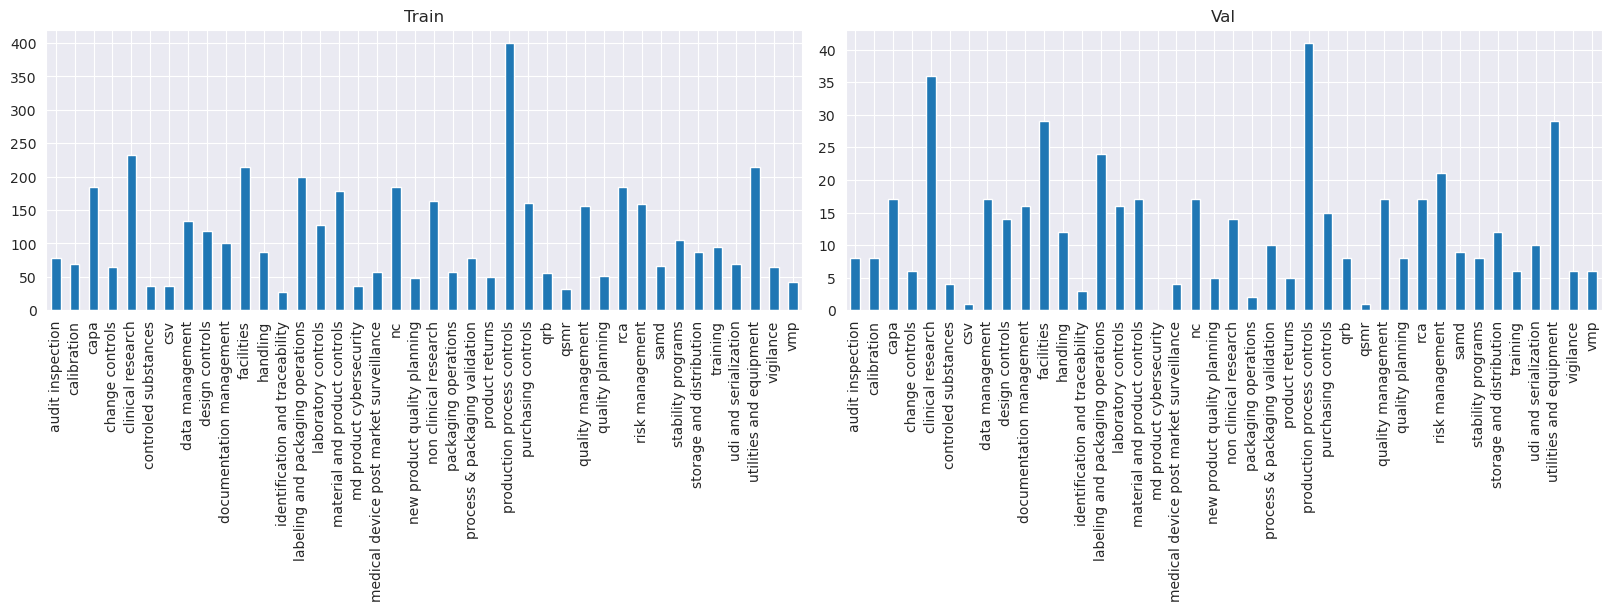

In [7]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
Y_train.sum(axis=0).plot.bar(ax=ax[0])
Y_val.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Train") 
ax[1].set_title("Val");

Custom Dataset class for training model

In [8]:
class JJDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: AutoTokenizer,
        max_length: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        row = self.data.iloc[index]
        text = row[ORIGINAL_TEXT]
        target = row[features.mlb.classes_]

        inputs = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt'
        )

        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "token_type_ids": inputs["token_type_ids"].flatten(),
            "target": torch.FloatTensor(target)
        }

Select pre-trained transformer model from Hugging Face

Load the tokenizer

In [9]:
MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


Distribution of token length based on tokenizer - helps decide max_tokens for training model

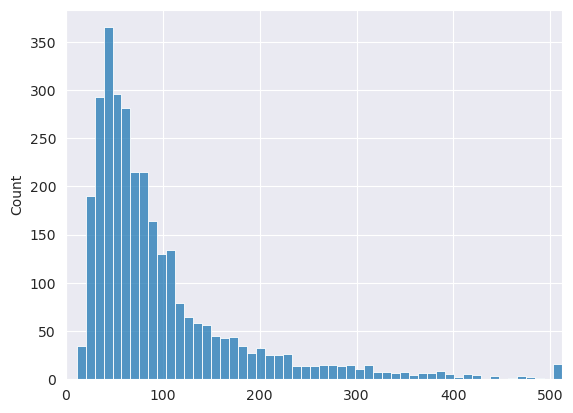

In [10]:
token_counts = []
for _, row in train.iterrows():
    tokens = tokenizer.encode(
        row[ORIGINAL_TEXT],
        max_length=512,
        truncation=True
    )
    token_counts.append(len(tokens))

sns.histplot(token_counts)
plt.xlim([0, 512]);

Custom model class with classifier head

In [11]:
class Model(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.l2 = nn.Dropout(0.3)
        self.l3 = nn.Linear(self.l1.config.hidden_size, len(features.mlb.classes_))

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.l1(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        out = self.l2(out.pooler_output)
        out = self.l3(out)
        return out

# Build model
model = Model(MODEL_NAME)
model.to(device);

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Hyperparameters

In [12]:
MAX_TOKEN_COUNT = 256
TRAIN_BATCH = 32
VALID_BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 1e-05
NUM_WORKERS = 0

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
saved_models_path = Path(os.path.join(data.current_path, SAVED_MODELS))
saved_models_path.mkdir(parents=True, exist_ok=True)

Build dataloaders

In [14]:
train_dataset = JJDataset(
    train,
    tokenizer,
    max_length=MAX_TOKEN_COUNT
)
valid_dataset = JJDataset(
    val,
    tokenizer,
    max_length=MAX_TOKEN_COUNT
)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=VALID_BATCH_SIZE, num_workers=NUM_WORKERS)

Train

In [15]:
# Move model to device
model.to(device)
# Lists to keep the losses at the end of each epoch
train_loss, valid_loss = list(), list()
for epoch in range(EPOCHS):
    # Dummy lists to keep the losses at the end of each iteration
    # (one batch forward and backward process)
    train_batch_loss, valid_batch_loss = list(), list()
    # Training mode
    model.train()
    for i, item in enumerate(train_loader):
        # Move input to device
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)
        # Forward pass
        out = model(input_ids, attention_mask, token_type_ids)
        # Calculate loss
        loss = criterion(out, target)
        # Reset gradients
        optimizer.zero_grad()
        # Backward pass (backpropogation)
        loss.backward()
        # Update weights
        optimizer.step()
        # Collect loss
        train_batch_loss.append(loss.item())
        message = \
            f"EPOCH:{epoch+1}/{EPOCHS}, " + \
            f"step:{i+1}/{len(train_loader)}, " + \
            f"loss={loss.item()}"
        print("\r", message, end="")
    # Take the average of iteration losses
    # and append it to the epoch losses list
    train_loss.append(np.array(train_batch_loss).mean())
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        for i, item in enumerate(valid_loader):
            # Move input to device
            input_ids = item["input_ids"].to(device, dtype=torch.long)
            attention_mask = item["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
            target = item["target"].to(device, dtype=torch.float)
            # Forward pass
            out = model(input_ids, attention_mask, token_type_ids)
            # Calculate loss
            loss = criterion(out, target)
            valid_batch_loss.append(loss.item())
            message = \
                f"EPOCH:{epoch+1}/{EPOCHS}, " + \
                f"step:{i+1}/{len(valid_loader)}, " + \
                f"loss={loss.item()}"
            print("\r", message, end="")
    # Take the average of iteration losses
    # and append it to the epoch losses list
    valid_loss.append(np.array(valid_batch_loss).mean())
    message = \
        f"EPOCH:{epoch+1}/{EPOCHS} - " + \
        f"Training Loss: {train_loss[-1]}, " + \
        f"Validation Loss: {valid_loss[-1]}"
    print("\r", message)
    # Save model
    state = f"epoch_{epoch+1:03}.pth"
    state_dict_path = os.path.join(saved_models_path, state)
    torch.save(model.state_dict(), state_dict_path)

 EPOCH:1/60 - Training Loss: 0.43643391285974953, Validation Loss: 0.2666393355889754
 EPOCH:2/60 - Training Loss: 0.23165226274544432, Validation Loss: 0.1907995559952476
 EPOCH:3/60 - Training Loss: 0.18370107277152464, Validation Loss: 0.16614685410803015
 EPOCH:4/60 - Training Loss: 0.16557160219580858, Validation Loss: 0.15593003820289264
 EPOCH:5/60 - Training Loss: 0.15780047150616794, Validation Loss: 0.15071669220924377
 EPOCH:6/60 - Training Loss: 0.1525066201527094, Validation Loss: 0.14545169337229294
 EPOCH:7/60 - Training Loss: 0.14698949287232665, Validation Loss: 0.13951075077056885
 EPOCH:8/60 - Training Loss: 0.139012241793662, Validation Loss: 0.13200531832196497
 EPOCH:9/60 - Training Loss: 0.1322387449981011, Validation Loss: 0.1263283755291592
 EPOCH:10/60 - Training Loss: 0.12468330124297093, Validation Loss: 0.11860353973778812
 EPOCH:11/60 - Training Loss: 0.11686709384942792, Validation Loss: 0.112372948364778
 EPOCH:12/60 - Training Loss: 0.10972158879656152,

Chose model state at lowest validation loss and set to evaluation mode

In [16]:
best_epoch = np.argmin(valid_loss) + 1
print(f"Best epoch: {best_epoch}")
state = f"epoch_{best_epoch:03}.pth"
state_dict_path = os.path.join(saved_models_path, state)
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

Best epoch: 47


Train vs Validation loss

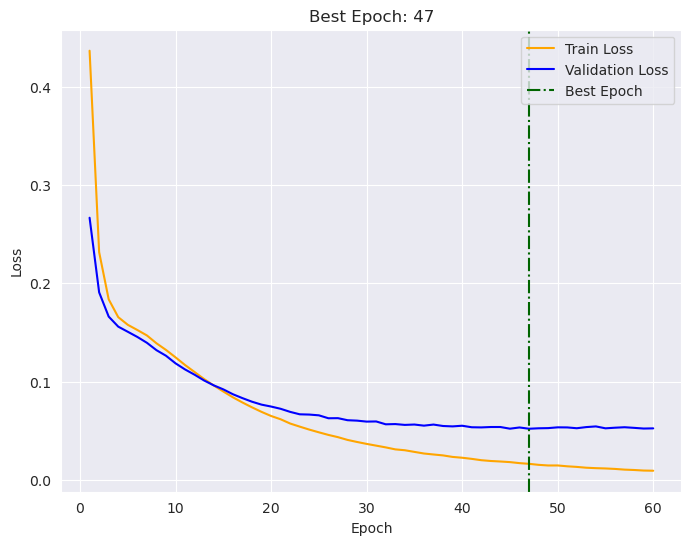

In [17]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS+1), train_loss, label="Train Loss", color="orange")
plt.plot(range(1, EPOCHS+1), valid_loss, label="Validation Loss", color="blue")
plt.axvline(x=best_epoch, label="Best Epoch", color="darkgreen", linestyle="dashdot")
plt.xlabel("Epoch")
plt.ylabel(f"Loss")
plt.title(f"Best Epoch: {best_epoch}")
plt.legend(loc="upper right");

Evaluate on validation set

In [18]:
# Custom evaluation class for evaluation
eval = CustomEvaluation()

In [19]:
valid_dataset = JJDataset(
    val,
    tokenizer,
    max_length=MAX_TOKEN_COUNT
)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
y_pred_probab = []
with torch.no_grad():
    for i, item in enumerate(valid_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

y_true_val = np.array(y_true).astype(int)
y_pred_probab_val = np.array(y_pred_probab)
y_pred_val = np.where(y_pred_probab_val > .5, 1, 0)

In [20]:
eval.compute_sample_wise_metrics(y_true=y_true_val, y_pred=y_pred_val)

Hamming Loss    0.013188
Accuracy        0.704348
Precision       0.837440
Recall          0.784976
F1 Score        0.797447
F2 Score        0.787741
dtype: float64

Evaluate on test dataset

In [21]:
test_dataset = JJDataset(
    test,
    tokenizer,
    max_length=MAX_TOKEN_COUNT
)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
y_pred_probab = []
with torch.no_grad():
    for i, item in enumerate(test_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

y_true_test = np.array(y_true).astype(int)
y_pred_probab_test = np.array(y_pred_probab)
y_pred_test = np.where(y_pred_probab_test > .5, 1, 0)

In [22]:
eval.compute_sample_wise_metrics(y_true=y_true_test, y_pred=y_pred_test)

Hamming Loss    0.013151
Accuracy        0.723958
Precision       0.868056
Recall          0.836226
F1 Score        0.833794
F2 Score        0.831114
dtype: float64

Label-wise evaluation on test dataset

In [23]:
eval.compute_label_wise_metrics(
    y_true=y_true_test,
    y_pred=y_pred_test,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,F2 Score,Development Samples,Test Samples
audit inspection,0.818182,1.000000,0.900000,0.957447,86,9
calibration,1.000000,0.666667,0.800000,0.714286,78,6
capa,0.882353,0.750000,0.810811,0.773196,202,20
change controls,1.000000,0.555556,0.714286,0.609756,71,9
clinical research,0.964286,0.931034,0.947368,0.937500,269,29
controled substances,1.000000,0.833333,0.909091,0.862069,40,6
csv,0.000000,0.000000,0.000000,0.000000,37,3
data management,0.857143,0.923077,0.888889,0.909091,150,13
design controls,0.769231,0.909091,0.833333,0.877193,132,11
documentation management,0.833333,0.769231,0.800000,0.781250,117,13


Save predictions

In [24]:
pred_df = test[[ORIGINAL_TEXT, TARGET]].copy()
y_pred_test_inv = [list(y) for y in features.mlb.inverse_transform(y_pred_test)]
pred_df[PREDICTION] = y_pred_test_inv
save_to = os.path.join(data.reports_path, "bert-evaluation.pkl")
pred_df.to_pickle(save_to)

Save fine-tuned model

In [25]:
model_path = os.path.join(data.reports_path, "bert-model.pth")
torch.save(model.state_dict(), model_path)